##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved.

The dataset is downloaded from the public docket at:
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [157]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [158]:
orig_df = pd.read_csv('/content/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [159]:
df = pd.read_csv('/content/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [160]:
df['X'] = df['X']
df['Y'] = df['Y']
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [161]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [162]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means.
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data?


In [163]:
df.head()
df.describe()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000
mean,-115.159326,36.143360,3.978182,0.909091,2.981818,11.236364,0.712727
std,0.101294,0.118418,3.045799,0.334878,1.924590,7.039937,0.978427
min,-116.000000,35.068419,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-115.209198,36.114704,1.000000,1.000000,1.000000,5.000000,0.000000
50%,-115.149945,36.152415,3.000000,1.000000,3.000000,11.000000,0.000000
75%,-115.105200,36.183854,6.000000,1.000000,5.000000,18.000000,1.000000
max,-114.625570,37.000000,11.000000,2.000000,6.000000,23.000000,6.000000


'X' = Latitude of the location where crime was reported.
'Y' = Longitude of the location where crime was reported.
'Area_Command' = The police designation of the bureau of the operation.
'NIBRSOffenseCode' = The classification code for the crime committed.
'DayOfWeek' = A day in a week on which crime was committed in integer from 0 to 6.
'Time' = The time when crime was reported in terms of hours in interger from 0 to 23.
'VictimCount' = Total number of victims involved in the reported crime.

Input Variables: These are the features used to predict the target variable. In our case, input features are 'X', 'Y', 'Area_Command', 'NIBRSOffenseCode','DayOfWeek', 'Time'.
 Target Variable: This is what we want to predict. In our case, target variable is 'VictimCount'.

The range of values for 'X': -116.0 to -114.6255705
The range of values for 'Y': 35.0684190000001 to 37.0000000000001
The range of values for 'Area_Command': 0 to 11
The range of values for 'NIBRSOffenseCode': 0 to 2
The range of values for 'DayOfWeek': 0 to 6
The range of values for 'Time': 0 to 23
The range of values for 'VictimCount': 0 to 6

The features latitude and longitude will be required to be normalized.



In [164]:
print("X Range: ({}, {})".format(df['X'].min(), df['X'].max()))
print("Y Range: ({}, {})".format(df['Y'].min(), df['Y'].max()))
print("Area_Command Range: ({}, {})".format(df['Area_Command'].min(), df['Area_Command'].max()))

X Range: (-116.0, -114.6255705)
Y Range: (35.0684190000001, 37.0000000000001)
Area_Command Range: (0, 11)


## Task 2

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data.

In [165]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split

# Define a custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.targets[idx]
        return x, y

# Assuming you have X and y as NumPy arrays
X = torch.tensor(df.drop('VictimCount', axis=1).values.astype(np.float32))
y = torch.tensor(df['VictimCount'].values.astype(np.float32))

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Create custom Datasets for training and test data
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

# Create DataLoaders for training and test data
batch_size = 49
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Iterate through the training loader to check the structure
for batch_idx, (x, y) in enumerate(train_loader):
    print(f"Batch {batch_idx}, X: {x.shape}, Y: {y.shape}")
    print("Sample from X:", x[3, :], "Size: ", x[3, :].shape)
    break


Batch 0, X: torch.Size([49, 6]), Y: torch.Size([49])
Sample from X: tensor([-115.2544,   36.0831,    3.0000,    1.0000,    1.0000,    8.0000]) Size:  torch.Size([6])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem.

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it.

In [166]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split

# Define the custom dataset as shown in the previous response
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.targets[idx]
        return x, y

# Define a custom neural network class
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNetwork, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Assuming you have X and y as NumPy arrays
X = torch.tensor(df.drop('VictimCount', axis=1).values.astype(np.float32))
y = torch.tensor(df['VictimCount'].values.astype(np.float32))

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Create custom Datasets for training and test data
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

# Create DataLoaders for training and test data
batch_size = 40
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define the neural network model
input_size = X.shape[1]  # Adjust this based on the number of features
hidden_sizes = [20, 10, 5]  # Define the number of hidden units in each layer
output_size = 1  # Predicting a single value
model = NeuralNetwork(input_size, hidden_sizes, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# This loop will go through batches of data, perform forward and backward passes, and update the weights of the network. Additionally, the total loss on the test dataset is calculated for each epoch.
num_epochs = 180
for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    total_loss = 0
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        total_loss += criterion(outputs, batch_y).item()
    avg_mse = total_loss / len(test_loader)
    print(f'Epoch [{epoch + 1}], MSE Loss: {avg_mse:.4f}')


Epoch [1], MSE Loss: 2.3288
Epoch [2], MSE Loss: 1.9930
Epoch [3], MSE Loss: 1.7399
Epoch [4], MSE Loss: 1.5504
Epoch [5], MSE Loss: 1.4119
Epoch [6], MSE Loss: 1.3077
Epoch [7], MSE Loss: 1.2294
Epoch [8], MSE Loss: 1.1940
Epoch [9], MSE Loss: 1.1900
Epoch [10], MSE Loss: 1.1816
Epoch [11], MSE Loss: 1.1690
Epoch [12], MSE Loss: 1.1553
Epoch [13], MSE Loss: 1.1403
Epoch [14], MSE Loss: 1.1238


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

Epoch [15], MSE Loss: 1.1107
Epoch [16], MSE Loss: 1.1024
Epoch [17], MSE Loss: 1.0929
Epoch [18], MSE Loss: 1.0827
Epoch [19], MSE Loss: 1.0721
Epoch [20], MSE Loss: 1.0622
Epoch [21], MSE Loss: 1.0528
Epoch [22], MSE Loss: 1.0437
Epoch [23], MSE Loss: 1.0347
Epoch [24], MSE Loss: 1.0258
Epoch [25], MSE Loss: 1.0169
Epoch [26], MSE Loss: 1.0081
Epoch [27], MSE Loss: 0.9994
Epoch [28], MSE Loss: 0.9907
Epoch [29], MSE Loss: 0.9821
Epoch [30], MSE Loss: 0.9736
Epoch [31], MSE Loss: 0.9650
Epoch [32], MSE Loss: 0.9563
Epoch [33], MSE Loss: 0.9475
Epoch [34], MSE Loss: 0.9387
Epoch [35], MSE Loss: 0.9300
Epoch [36], MSE Loss: 0.9212
Epoch [37], MSE Loss: 0.9122
Epoch [38], MSE Loss: 0.9032
Epoch [39], MSE Loss: 0.8941
Epoch [40], MSE Loss: 0.8848
Epoch [41], MSE Loss: 0.8755
Epoch [42], MSE Loss: 0.8659
Epoch [43], MSE Loss: 0.8559
Epoch [44], MSE Loss: 0.8460
Epoch [45], MSE Loss: 0.8355
Epoch [46], MSE Loss: 0.8250
Epoch [47], MSE Loss: 0.8138
Epoch [48], MSE Loss: 0.8022
Epoch [49], MS

## Task 4

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem.

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?

In [167]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split

# Define the custom dataset as shown in the previous responses
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.targets[idx]
        return x, y


class ClassificationModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(ClassificationModel, self).__init__()
        self.layer_1 = nn.Linear(input_size, 20)
        self.layer_2 = nn.Linear(20, 10)
        self.layer_3 = nn.Linear(10, 5)
        self.layer_4 = nn.Linear(5, output_size)

    def forward(self, x):
        a_1 = self.layer_1(x)
        h_1 = a_1
        a_2 = self.layer_2(h_1)
        h_2 = a_2
        a_3 = self.layer_3(h_2)
        h_3 = a_3
        a_4 = self.layer_4(h_3)
        pred_output = a_4
        return pred_output








# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Assuming you have X and y as NumPy arrays, and y is categorical labels (integers)
X = torch.tensor(df.drop('VictimCount', axis=1).values.astype(np.float32))
y = torch.tensor(df['VictimCount'].values)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Create custom Datasets for training and test data
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

# Create DataLoaders for training and test data
batch_size = 40
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define the classification model
input_size = X.shape[1]  # Adjust this based on the number of features
output_size = len(torch.unique(y))  # The number of unique classes in the target
model = ClassificationModel(input_size, output_size)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# This loop will go through batches of data, perform forward and backward passes, and calculate accuracy on the test dataset.
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Training the model
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            output = model(inputs)
            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%')


Epoch [1], Loss: 1.7231, Accuracy: 50.60%
Epoch [2], Loss: 1.5254, Accuracy: 50.60%
Epoch [3], Loss: 1.3022, Accuracy: 37.35%
Epoch [4], Loss: 1.2803, Accuracy: 50.60%
Epoch [5], Loss: 0.9848, Accuracy: 37.35%
Epoch [6], Loss: 1.5509, Accuracy: 50.60%
Epoch [7], Loss: 0.9563, Accuracy: 50.60%
Epoch [8], Loss: 1.4716, Accuracy: 50.60%
Epoch [9], Loss: 1.1015, Accuracy: 50.60%
Epoch [10], Loss: 0.9204, Accuracy: 50.60%
Epoch [11], Loss: 1.2549, Accuracy: 50.60%
Epoch [12], Loss: 1.1368, Accuracy: 50.60%
Epoch [13], Loss: 1.0199, Accuracy: 51.81%
Epoch [14], Loss: 1.1428, Accuracy: 50.60%
Epoch [15], Loss: 0.9394, Accuracy: 51.81%
Epoch [16], Loss: 1.3405, Accuracy: 50.60%
Epoch [17], Loss: 0.8691, Accuracy: 50.60%
Epoch [18], Loss: 0.9113, Accuracy: 50.60%
Epoch [19], Loss: 1.0394, Accuracy: 50.60%
Epoch [20], Loss: 1.1438, Accuracy: 50.60%
Epoch [21], Loss: 1.0174, Accuracy: 50.60%
Epoch [22], Loss: 1.0403, Accuracy: 49.40%
Epoch [23], Loss: 1.0524, Accuracy: 50.60%
Epoch [24], Loss: 1.

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

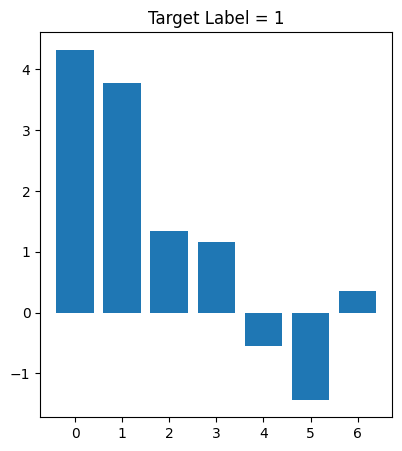

In [170]:
# In tasks 3 and 4, we addressed two different types of machine learning problems: regression and classification.
# Task 3 focused on predicting a real number, specifically the number of crime victims. We used a regression model and Mean Squared Error (MSE) loss function.
# Task 4, on the other hand, involved classifying the number of crime victims into one of seven categories. We employed a classification model with a softmax activation function and Cross Entropy loss.

# Comparing the results, the classification task (Task 4) worked better for this particular problem.
# This is likely because classifying into predefined categories can be more suitable when dealing with discrete outcomes.
# The classification model provides a clearer understanding of different victim count groups and its relationship with input features.






import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Evaluate the model and get predictions
output = model(X_test)
_, pred = torch.max(output.data, 1)

misclassified_index = None

# Find the first misclassified sample
for i in range(len(pred)):
    if pred[i] != y_test[i]:
        misclassified_index = i
        break

if misclassified_index is not None:
    misclassified_output = output[misclassified_index]

    # Create a bar graph for the predicted class probabilities
    plt.figure(figsize=(10, 5))

    plt.subplot(121)
    plt.bar(range(output.shape[1]), misclassified_output.detach().numpy())
    plt.xticks(range(output.shape[1]))
    plt.title('Target Label = {}'.format(y_test[misclassified_index].item()))

    plt.show()
else:
    print("No misclassified samples found.")


## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


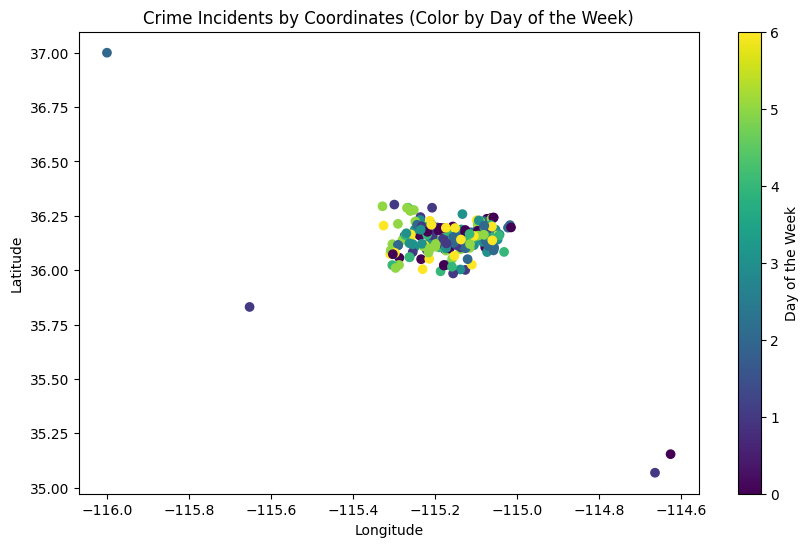

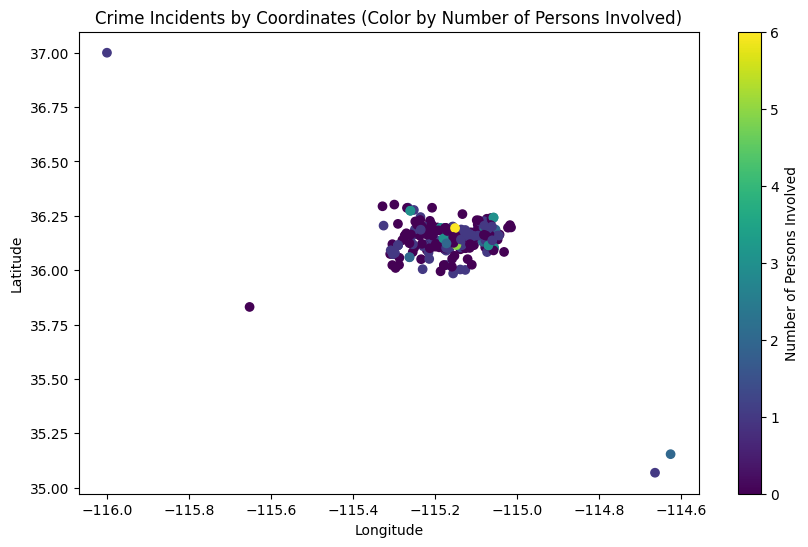

Reported crime based on the day of the week:
4    51
3    44
5    43
0    40
1    37
2    32
6    28
Name: DayOfWeek, dtype: int64
Most frequent day: 4


In [169]:
import numpy as np
import matplotlib.pyplot as plt

# Scatter plot by coordinates, color by day of the week
plt.figure(figsize=(10, 6))
plt.scatter(df['X'], df['Y'], c=df['DayOfWeek'], cmap='viridis', vmin=df['DayOfWeek'].min(), vmax=df['DayOfWeek'].max())
plt.colorbar(label='Day of the Week')
plt.title('Crime Incidents by Coordinates (Color by Day of the Week)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Scatter plot by coordinates, color by number of persons involved
plt.figure(figsize=(10, 6))
plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='viridis', vmin=df['VictimCount'].min(), vmax=df['VictimCount'].max())
plt.colorbar(label='Number of Persons Involved')
plt.title('Crime Incidents by Coordinates (Color by Number of Persons Involved)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Print reported crime based on the day of the week
print("Reported crime based on the day of the week:")
crimes_by_day = df['DayOfWeek'].value_counts()
print(crimes_by_day)

# Find the most frequent day
most_frequent_day = crimes_by_day.idxmax()
print("Most frequent day:", most_frequent_day)
